# Planning phase

## Goals

1. Present the recommended way of doing posterior predictive sampling (`pm.Data`)
2. Some caveats of using `theano.shared`
3. Present the way that uses factory functions
4. How to handle cases with inferred cluster labels that should be removed.

## Presentation skeleton

0. Personal introduction
1. Describe some small problems where you need to make predictions
2. Talk about forward sampling and what predictions mean in the context of MCMC posterior approximations
3. Introduce the default way with `pm.Data`, `set_value` and `sample_posterior_predictive`
4. Show a situation where the default breaks
5. Take a peek into the depths of `random` -> `draw_values` -> `random`
6. _Don't kid yourself Jimmy, if a shape problem ever got the chance it would eat you and everyone you cared about_
7. How does pymc4 do things?
8. Can we do the same with pymc3? Yes, with factory functions for models
9. But these also fail for models where the inferred labels depend on the data
10. Take the bad weed out of the trace to allow for posterior predictive sampling
11. Can this process be automated? Yes, but we need a better graph representation of the model
12. Call for contributions with symbolic stuff

In [1]:
import numpy as np
from theano import tensor as tt
import pymc3 as pm
import arviz as az
from matplotlib import pyplot as plt

## Simple model without posterior predictive problems

In [2]:
true_slope = 1
true_intercept = 5

In [3]:
x_train1 = np.linspace(-1, 2, 21)
y_train1 = (
    true_slope * x_train1 +
    true_intercept +
    np.random.randn(*x_train1.shape)
)

In [4]:
x_test1 = np.linspace(-3, 5, 10)
y_test1 = (
    true_slope * x_test1 +
    true_intercept +
    np.random.randn(*x_test1.shape)
)

In [5]:
coords1 = {"obs_ind": np.arange(len(x_train1))}

In [6]:
with pm.Model(coords=coords1) as simple_model:
    regressor = pm.Data("x", x_train1, dims="obs_ind")
    slope = pm.Normal("slope", 0, 10)
    intercept = pm.Normal("intercept", 0, 10)
    mu = slope * regressor + intercept
    output = pm.Data("y", y_train1)
    pm.Normal("observed", mu=mu, sigma=1, observed=output, dims="obs_ind")
    
    prior = pm.sample_prior_predictive()
    trace = pm.sample(tune=2000)
    ppc = pm.fast_sample_posterior_predictive(trace)
    simple_idata = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=ppc)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, slope]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 4 seconds.
The acceptance probability does not match the target. It is 0.8787803599806036, but should be close to 0.8. Try to increase the number of tuning steps.


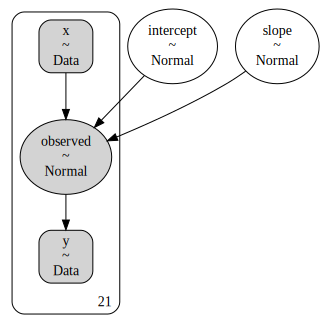

In [7]:
pm.model_to_graphviz(simple_model)

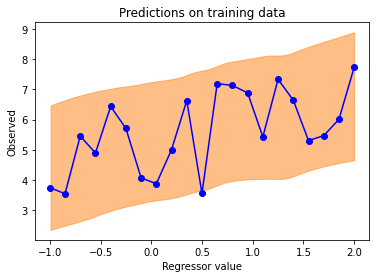

In [8]:
fig, ax = plt.subplots(1, 1)
ax.plot(x_train1, y_train1, "-ob")
az.plot_hdi(
    x_train1,
    simple_idata.posterior_predictive["observed"],
    ax=ax,
    hdi_prob=0.95,
)
ax.set_xlabel("Regressor value")
ax.set_ylabel("Observed")
ax.set_title("Predictions on training data");

## Lets make some predictions on new data

- Added difficulty: test data has different shape than training data

In [9]:
with simple_model:
    pm.set_data(
        dict(
            x=x_test1,
            y=y_test1,
        )
    )
    ppc2 = pm.fast_sample_posterior_predictive(simple_idata)

/home/lpaz/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


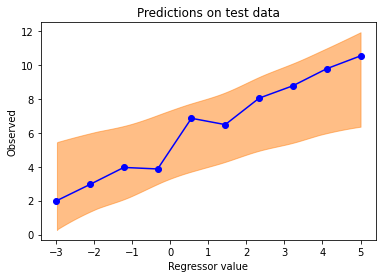

In [10]:
fig, ax = plt.subplots(1, 1)
ax.plot(x_test1, y_test1, "-ob")
az.plot_hdi(
    x_test1,
    ppc2["observed"],
    ax=ax,
    hdi_prob=0.95,
)
ax.set_xlabel("Regressor value")
ax.set_ylabel("Observed")
ax.set_title("Predictions on test data");

### A bad omen:

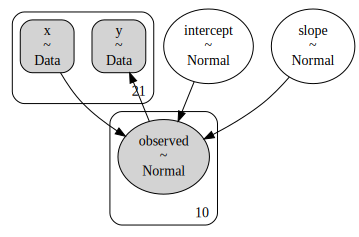

In [11]:
pm.model_to_graphviz(simple_model)

It's actually not so bad. The `pm.Data`'s dshape is only ever used for model_to_graphviz so it has no other consequence. 

## Shape problems creep in

![A shape problem would eat you and everyone you cared about](https://i.redd.it/oixpf3vlye7z.jpg)

Troy McClure: _Don't kid yourself Jimmy! If a shape problem ever got the chance, it'd eat you and everyone you care about!_

## Shape problems creep in

- Our distributions __are not theano tensors__
- Distribution shape __is not inferred from the parameters__
- Distribution shape __is detached from any change performed by `set_data`__

Things get messy as soon as some distribution's shape depends on variable data

#### A model with an unknown latent label per data point

In [12]:
n_components = 2
component_probability = np.random.rand(n_components)
component_probability/= np.sum(component_probability)

In [13]:
true_slopes = np.arange(n_components) * 2 + 1
true_intercept = 5

In [14]:
x_train2 = np.linspace(-1, 2, 21)
label_train2 = np.random.choice(
    n_components, p=component_probability, size=x_train2.shape
)
y_train2 = (
    true_slopes[label_train2] * x_train2 +
    true_intercept +
    np.random.randn(*x_train1.shape)
)
coords2 = {"obs_ind": np.arange(len(x_train2)), "component": np.arange(n_components)}

In [15]:
x_test2 = np.linspace(-3, 5, 10)
label_test2 = np.random.choice(
    n_components, p=component_probability, size=x_test2.shape
)
y_test2 = (
    true_slopes[label_test2] * x_test2 +
    true_intercept +
    np.random.randn(*x_test2.shape)
)

In [16]:
with pm.Model(coords=coords2) as latent_label_model:
    regressor = pm.Data("x", x_train2, dims="obs_ind")
    label = pm.Categorical("label", p=component_probability, dims="obs_ind")
    slope = pm.Normal("slope", 0, 10, dims="component")
    intercept = pm.Normal("intercept", 0, 10)
    mu = slope[label] * regressor + intercept
    output = pm.Data("y", y_train2)
    observed = pm.Normal("observed", mu=mu, sigma=1, observed=output, dims="obs_ind")
    
    prior = pm.sample_prior_predictive()
    trace = pm.sample(tune=3000)
    ppc = pm.fast_sample_posterior_predictive(trace)
    latent_label_idata = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=ppc)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>BinaryGibbsMetropolis: [label]
>NUTS: [intercept, slope]


Sampling 2 chains for 3_000 tune and 1_000 draw iterations (6_000 + 2_000 draws total) took 11 seconds.


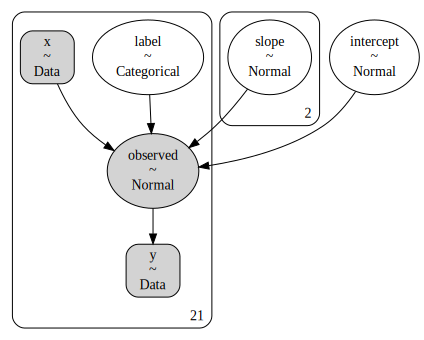

In [17]:
pm.model_to_graphviz(latent_label_model)

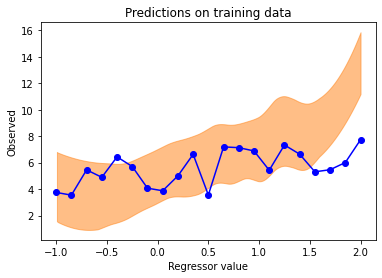

In [18]:
fig, ax = plt.subplots(1, 1)
ax.plot(x_train1, y_train1, "-ob")
az.plot_hdi(
    x_train1,
    latent_label_idata.posterior_predictive["observed"],
    ax=ax,
    hdi_prob=0.95,
)
ax.set_xlabel("Regressor value")
ax.set_ylabel("Observed")
ax.set_title("Predictions on training data");

### But what happens on new data?

In [19]:
with latent_label_model:
    pm.set_data(
        dict(
            x=x_test2,
            y=y_test2,
        )
    )
    try:
        ppc2 = pm.sample_posterior_predictive(latent_label_idata)
    except Exception as e:
        print(f"{e.__class__.__name__}: {e}")

ValueError: Input dimension mis-match. (input[0].shape[0] = 21, input[1].shape[0] = 10)
Apply node that caused the error: Elemwise{Composite{((i0 * i1) + i2)}}[(0, 0)](AdvancedSubtensor1.0, x, InplaceDimShuffle{x}.0)
Toposort index: 2
Inputs types: [TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, (True,))]
Inputs shapes: [(21,), (10,), (1,)]
Inputs strides: [(8,), (8,), (8,)]
Inputs values: ['not shown', 'not shown', array([4.4790877])]
Outputs clients: [['output']]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.


### But why?

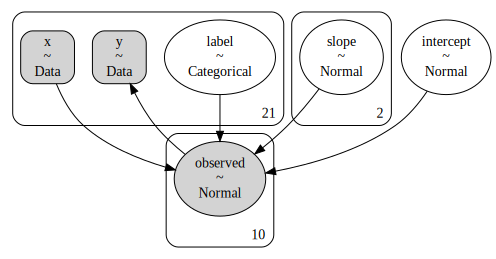

In [20]:
pm.model_to_graphviz(latent_label_model)

#### `pm.set_data` doesn't change `label`'s shape!!!

## What if we try to marginalize `label` out of the model?

In [21]:
with pm.Model(coords=coords2) as scalar_mixture_model:
    regressor = pm.Data("x", x_train2, dims="obs_ind")
    slope = pm.Normal("slope", 0, 10, dims="component")
    intercept = pm.Normal("intercept", 0, 10)
    mu = slope * regressor[..., None] + intercept
    output = pm.Data("y", y_train2)
    observed = pm.NormalMixture(
        "observed",
        w=component_probability,
        mu=mu,
        sigma=1,
        observed=output,
        comp_shape=(len(x_train2), n_components),
        dims="obs_ind",
    )
    
    prior = pm.sample_prior_predictive()
    trace = pm.sample(tune=3000)
    ppc = pm.fast_sample_posterior_predictive(trace)
    scalar_mixture_idata = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=ppc)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, slope]


Sampling 2 chains for 3_000 tune and 1_000 draw iterations (6_000 + 2_000 draws total) took 5 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


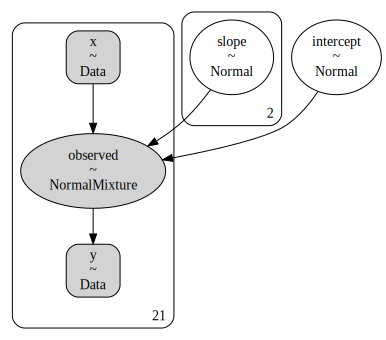

In [22]:
pm.model_to_graphviz(scalar_mixture_model)

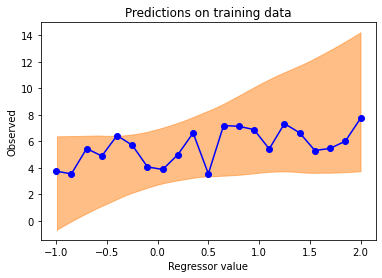

In [23]:
fig, ax = plt.subplots(1, 1)
ax.plot(x_train1, y_train1, "-ob")
az.plot_hdi(
    x_train1,
    scalar_mixture_idata.posterior_predictive["observed"],
    ax=ax,
    hdi_prob=0.95,
)
ax.set_xlabel("Regressor value")
ax.set_ylabel("Observed")
ax.set_title("Predictions on training data");

### But what happens with the test data?

In [24]:
with scalar_mixture_model:
    pm.set_data(
        dict(
            x=x_test2,
            y=y_test2,
        )
    )
    try:
        ppc2 = pm.sample_posterior_predictive(scalar_mixture_idata)
    except Exception as e:
        print(f"{e.__class__.__name__}: {e}")

ValueError: Cannot broadcast provided shapes (10, 2), (), (21, 2) given size: (1,)


### But why?

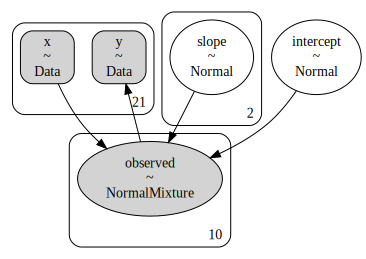

In [25]:
pm.model_to_graphviz(scalar_mixture_model)

- __NOT APPARENT FROM THE GRAPH!__
- The Mixture's __component distributions shape does not change__
- It's set when the distribution is constructed

### What to do?

![Try not to cry](https://i.kym-cdn.com/entries/icons/original/000/012/073/7686178464_fdc8ea66c7.jpg)

### Or...

## Functional approach

### We need to define a factory function to make models on new data

Pros:

- We can work around shape problems for posterior predictive sampling
- Can change any aspect of the model based on new data

Cons:

- Manual tunning
- Repeated model compilation
- Potential need to remove entries from posterior trace
- Added overhead of plotting
- __We shouldn't have to do this...__

In [26]:
def scalar_mixture_model_factory(coords, x, y):
    with pm.Model(coords=coords) as model:
        regressor = pm.Data("x", x, dims="obs_ind")
        slope = pm.Normal("slope", 0, 10, dims="component")
        intercept = pm.Normal("intercept", 0, 10)
        mu = slope * regressor[..., None] + intercept
        output = pm.Data("y", y)
        observed = pm.NormalMixture(
            "observed",
            w=component_probability,
            mu=mu,
            sigma=1,
            observed=output,
            comp_shape=(len(x), n_components),
            dims="obs_ind",
        )
    return model

In [27]:
with scalar_mixture_model_factory(coords2, x_train2, y_train2):
    prior = pm.sample_prior_predictive()
    trace = pm.sample(tune=3000)
    ppc = pm.fast_sample_posterior_predictive(trace)
    scalar_mixture_idata = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=ppc)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, slope]


Sampling 2 chains for 3_000 tune and 1_000 draw iterations (6_000 + 2_000 draws total) took 6 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


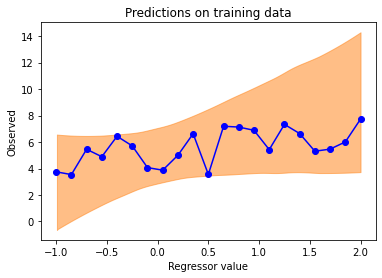

In [28]:
fig, ax = plt.subplots(1, 1)
ax.plot(x_train1, y_train1, "-ob")
az.plot_hdi(
    x_train1,
    scalar_mixture_idata.posterior_predictive["observed"],
    ax=ax,
    hdi_prob=0.95,
)
ax.set_xlabel("Regressor value")
ax.set_ylabel("Observed")
ax.set_title("Predictions on training data");

/home/lpaz/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


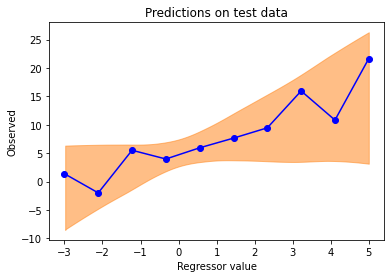

In [29]:
coords3 = coords2.copy()
coords3["obs_ind"] = np.arange(len(x_test2))
with scalar_mixture_model_factory(coords3, x_test2, y_test2):
    ppc = pm.fast_sample_posterior_predictive(trace)

fig, ax = plt.subplots(1, 1)
ax.plot(x_test2, y_test2, "-ob")
az.plot_hdi(
    x_test2,
    ppc["observed"],
    ax=ax,
    hdi_prob=0.95,
)
ax.set_xlabel("Regressor value")
ax.set_ylabel("Observed")
ax.set_title("Predictions on test data");